In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
from keras import layers, models
from keras.datasets import boston_housing
import numpy as np

Using TensorFlow backend.


In [41]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 17us/step


In [4]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [8]:
train_targets[0:11]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1])

In [9]:
m = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= m
train_data /= std

test_data -= m
test_data /= std

In [10]:
def build_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )
    return model      

In [19]:
k = 4
num_epochs = 350
num_examples_per_partition = len(train_data) // k
all_histories = []
for i in range(k):
    nepp = num_examples_per_partition
    x_val = train_data[i * nepp: (i + 1) * nepp]
    y_val = train_targets[i * nepp: (i + 1) * nepp]
    
    x_train = np.concatenate(
        [train_data[: i * nepp], 
         train_data[(i + 1) * nepp:]],
        axis=0)

    y_train = np.concatenate(
        [train_targets[: i * nepp], 
         train_targets[(i + 1) * nepp:]],
        axis=0)
    
    model = build_model((train_data.shape[1],))
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=num_epochs,
        batch_size=1,
        verbose=0)
    
    all_histories.append(history.history['val_mean_absolute_error'])

In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [21]:
type(history.history['val_mean_absolute_error'])

list

In [22]:
len(history.history['val_mean_absolute_error'])

350

In [32]:
avg_mae_history = [
    np.mean(
        [x[i] for x in all_histories]
    ) 
    for i in range(num_epochs)
]


In [34]:
len(avg_mae_history)

350

In [37]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(
                (1 - factor) * point + factor * prev
            )
        else:
            smoothed_points.append(point)
    return smoothed_points


In [38]:
smoothed_mae_history = smooth_curve(avg_mae_history[10:])

In [39]:
def adjust_axes(axis_obj, x_label_fontsize, y_label_fontsize, x_label_rotation=0, y_label_rotation=0):
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_label_fontsize)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_label_fontsize)
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_rotation(x_label_rotation)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_rotation(y_label_rotation)        

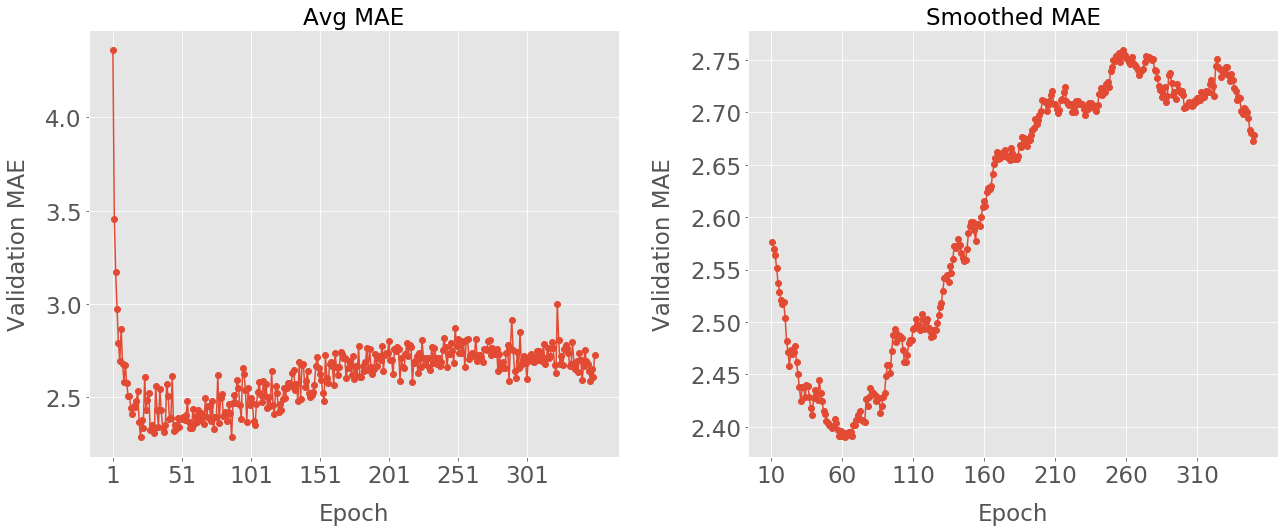

In [48]:
FONTSIZE = 23
plt.close('all')
fig = plt.figure(figsize=(18, 7.5))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])


# plot the raw avg_mae_history
ax = plt.subplot(gs[0, 0])
ax.plot(range(1, len(avg_mae_history) + 1), avg_mae_history, marker='o')
ax.set_xlabel('Epoch', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Validation MAE', fontsize=FONTSIZE, labelpad=15)
ax.set_xticks(np.arange(1, len(avg_mae_history)+1, 50))
adjust_axes(ax, FONTSIZE, FONTSIZE, 0, 0)
ax.set_title('Avg MAE', fontsize=FONTSIZE)


# plot the smoothed avg_mae_history
ax = plt.subplot(gs[0, 1])
ax.plot(10 + np.array(range(1, len(smoothed_mae_history) + 1)), smoothed_mae_history, marker='o')
ax.set_xlabel('Epoch', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Validation MAE', fontsize=FONTSIZE, labelpad=15)
ax.set_xticks(np.arange(10, len(smoothed_mae_history)+1, 50))
adjust_axes(ax, FONTSIZE, FONTSIZE, 0, 0)
ax.set_title('Smoothed MAE', fontsize=FONTSIZE)


plt.tight_layout(w_pad=3.0, h_pad=1)

### Use 60 epochs to train another model

In [58]:
model = build_model((train_data.shape[1],))
model.fit(
    train_data,
    train_targets,
    epochs=60, 
    batch_size=16,
    verbose=0
)

In [59]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 3ms/step


2.7655615245594696